# Laboratory #4_2 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification
*   Using pre-trained deep networks for feature extraction

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np

from skimage.feature import ORB 
from skimage.color import rgb2gray
from skimage.io import imread
from scipy.cluster.vq import vq
from skimage import color, data, exposure, feature, filters, io, transform 
from matplotlib import pyplot as plt
import skimage
from skimage import io
from sklearn.cluster import MiniBatchKMeans
import time

import os
import gzip

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [3]:
# modify the dataset variable with the path from your drive
dataset_path = r'/content/drive/MyDrive/MAI/CV/2021/Lab_CV/LAB8/p4_2_image_classification_using_BoVW/101_ObjectCategories'

In [4]:
categories = ['butterfly', 'kangaroo', 'dalmatian']
ncl = len(categories) * 10

In [5]:
#Function to load and create the dataset
import cv2
import random
from skimage.color import rgb2gray
dataset_img = []
img_size = 224
def create_datasetOne():
    for category in categories:
        path = os.path.join(dataset_path,category)  #Path to images in categories
        #categories = ['butterfly'=0 , 'kangaroo'= 1, 'dalmatian' = 2]
        class_num = categories.index(category)
        for img in os.listdir(path):
          try:
            img_array = cv2.imread(os.path.join(path,img))
            img_dataset = cv2.resize(img_array,(img_size,img_size))
            img_dataset = rgb2gray(img_dataset)

            dataset_img.append([img_dataset,class_num])
          except Exception as e:
            pass  
    # Shuffle the dataset
    random.shuffle(dataset_img)         

create_datasetOne()

*   Create a list of file and the corresponding labels

In [7]:
x = []
y = []
for features, label in dataset_img:
  x.append(features)
  y.append(label)

#x = np.array(x).reshape(-1,img_size,img_size,3).astype('float32')/255
x = np.array(x).astype('float32')
y = np.array(y).astype('float32')
print(f'The dimension of the dataset is : {x.shape}') 

The dimension of the dataset is : (244, 224, 224)


*   Create a train / test split where the test is 10% of the total data

In [10]:
from sklearn.model_selection import train_test_split

x_train, x_test, x_label_train, x_label_test = train_test_split(x, y, test_size=0.1)
print(x_train.shape)
print(x_test.shape)
print(x_label_train.shape)
print(x_label_test.shape)

(219, 224, 224)
(25, 224, 224)
(219,)
(25,)


*   How do you select the train/test split?

**Solution**

*Using the **train_test_split** function. The images have been previously shuffled randomly so that they are now picked in no specific order.*

...

## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 256 keypoints.


In [11]:
# solution
n_kp = 256
descriptor_extractor = ORB(n_keypoints=n_kp)

*   Extract ORB descriptors from all the images in the train set.


In [12]:
# solution
import cv2



desc_all_ORB = []
for i in range(len(x_train)):
  
  # We extract the descriptors for each image
  
  img = x_train[i]
  #img = cv2.cvtColor(x_train[i], cv2.COLOR_BGR2GRAY)
  #img =rgb2gray(x_train[i])
  
  descriptor_extractor.detect_and_extract(img) 
  descriptors = descriptor_extractor.descriptors
  # Save the descriptors in an global matrix
  desc_all_ORB.append(descriptors)

no_err_train = [i for i, v in enumerate(desc_all_ORB) if v.shape[0] != 256]

for ind in no_err_train:
    del desc_all_ORB[ind]
    x_train = np.delete(x_train, ind)
    x_label_train = np.delete(x_label_train, ind)

print(np.array(desc_all_ORB).shape)
print(x_train.shape)
print(x_label_train.shape)

(216,)
(10988541,)
(216,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [13]:
descriptor_list_train = np.array(desc_all_ORB).reshape(x_train.shape[0]*x_train.shape[1],x_train.shape[2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


IndexError: ignored

In [ ]:
# solution
import cv2

desc_all_ORB_test = []
for i in range(len(x_test)):
  # We extract the descriptors for each image
  img = cv2.cvtColor(x_test[i], cv2.COLOR_BGR2GRAY)
  descriptor_extractor.detect_and_extract(img) 
  descriptors = descriptor_extractor.descriptors
  # Save the descriptors in an global matrix
  desc_all_ORB_test.append(descriptors)

no_err_test = [i for i, v in enumerate(desc_all_ORB_test) if v.shape[0] != 256]

for ind in no_err_test:
    del desc_all_ORB_test[ind]
    x_test = np.delete(x_test, ind)
    x_label_test = np.delete(x_label_test, ind)

print(np.array(desc_all_ORB_test).shape)
print(x_test.shape)
print(x_label_test.shape)

descriptor_list_test = np.array(desc_all_ORB_test).reshape(219*256,256)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


(25,)

*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [ ]:
# solution
print(f'Descriptors generate with exit, the size of the descriptors is {len(desc_all_ORB)}')  
print(np.array(desc_all_ORB).shape)

Descriptors generate with exit, the size of the descriptors is 219
(219, 256, 256)


**Solution**

*For each image in the dataset, we look for 256 keypoints, each of which has an associated descriptor to it. The ORB detector uses binary descriptors, that is, vectors of Boolean type which in our case are of length 256.*

*Because there are 256 keypoints per image and we are taking 219 images for the train set, the size of the variable ('desc_all_ORB') that contains all of the descriptors is then: (219, 256, 256).*

...

### Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [ ]:
# Reshape the dataset to have a list with all the descriptors (n_descriptors = n_images x n_keypoints)
X = desc_all_ORB[0]
for i in range(1,len(x_train)):
  X = np.vstack((X,desc_all_ORB[i]))
# Convert list to array
X = np.array(X)
X.shape



(56064, 256)

In [ ]:
descriptor_list_train = np.array(desc_all_ORB).reshape(219*256,256)

In [ ]:
# solution
from sklearn.feature_extraction.image import extract_patches_2d

K = 3*10
kmeans = MiniBatchKMeans(n_clusters=K)#,batch_size=6,max_iter=10)
kmeans.fit(descriptor_list_train)
codebook = kmeans.cluster_centers_

In [ ]:
np.array(codebook).shape
# Each cluster center produced by k-means becomes a codevector, so we have 30 codevectors
# If we compare the codebook to a dictionary, each codevector represents one "word" in our Bag of Words

(30, 256)

*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

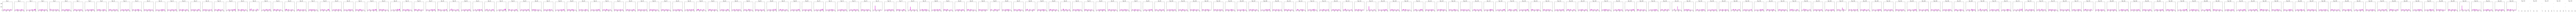

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input dat

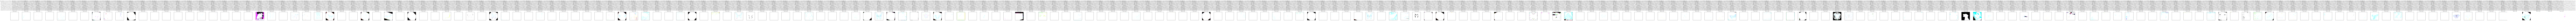

In [ ]:
# 1. Graphic histograms for every image in the treining set (219 images x 30 clusters)
import matplotlib.pyplot as plt

Y_train = kmeans.predict(descriptor_list_train)

histogram, ax = plt.subplots(1,len(x_train),figsize=(600,2))
for i in range(len(x_train)):
  ax[i].hist(Y_train[i*n_kp:(i+1)*n_kp], bins = K, color='magenta')
  ax[i].set_ylim([0, n_kp])
  ax[i].set_title("Fig. "+str(i+1))

for ax in histogram.get_axes():
    ax.label_outer()
plt.show()

# Representation of the images in the training set
images, axis = plt.subplots(1,len(x_train),figsize=(600,2))
for i in range(len(x_train)):
  d = (dataset_path+'/'+x_train[i])
  img = io.imread(d)
  axis[i].imshow(img)
  axis[i].axes.xaxis.set_visible(False)
  axis[i].axes.yaxis.set_visible(False)
  axis[i].set_title(x_label_train)
  #axis[i].set_title("Fig. "+str(i+1))
plt.show()

# NOTE: Click on the generated figures to englargen them

In [ ]:
# 2. Histogram matrix (219 images x 30 clusters)
histMatrix = np.zeros((len(x_train),K),"int32")
for i in range(len(x_train)):
  for j in range(n_kp):
    for k in range(K):
      if Y_train[i*n_kp+j]==k+1:
        histMatrix[i,k]+=1

from sklearn.preprocessing import StandardScaler
histMatrix = StandardScaler().fit_transform(histMatrix) # normalize the histogram matrix


# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


# The training-set has 219 figures, with features 
c_model = SVC(kernel = 'rbf')
param_grid = {'C':np.logspace(-3,4,18), 'gamma':np.logspace(-3,2,18)}


*   Use GridSearchCV to find the optimal value of C and Gamma.

In [ ]:
t0 = time.time()
classModel = GridSearchCV(c_model, param_grid)
classModel.fit(histMatrix,labels_train)
X_train = histMatrix

print("Best parameters set found by GridSearchCV:")
print()
print(classModel.best_params_)
print("Best score:")
print(classModel.best_score_)

print("--- Program executed in %s seconds ---" % (time.time() - t0))

Best parameters set found by GridSearchCV:

{'C': 0.7626985859023444, 'gamma': 0.003874675120456132}
Best score:
0.6160676532769556
--- Program executed in 10.420628786087036 seconds ---


# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [ ]:
# solution

# 1. Extract descriptors for the test-set (25 images, 256 descriptors per image):
import cv2

desc_all_ORB_test = []
for i in range(len(x_test)):
  # We extract the descriptors for each image
  img = cv2.cvtColor(x_test[i], cv2.COLOR_BGR2GRAY)
  descriptor_extractor.detect_and_extract(img) 
  descriptors = descriptor_extractor.descriptors
  # Save the descriptors in an global matrix
  desc_all_ORB_test.append(descriptors)

no_err_test = [i for i, v in enumerate(desc_all_ORB_test) if v.shape[0] != 256]

for ind in no_err_test:
    del desc_all_ORB_test[ind]
    x_test = np.delete(x_test, ind)
    x_label_test = np.delete(x_label_test, ind)

print(np.array(desc_all_ORB_test).shape)
print(x_test.shape)
print(x_label_test.shape)

********************************
0
[[False  True False ... False False  True]
 [False  True  True ... False False  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True False False ...  True False False]
 [False  True  True ... False False  True]
 [ True  True False ...  True  True  True]]
********************************
1
[[False False False ... False False False]
 [False  True False ... False  True  True]
 [ True False  True ... False False  True]
 ...
 [ True False False ...  True False  True]
 [ True  True False ... False  True  True]
 [False  True False ... False  True False]]
********************************
2
[[ True  True False ... False  True  True]
 [ True  True False ... False  True  True]
 [ True False  True ... False  True  True]
 ...
 [False False  True ... False False  True]
 [False False False ... False False  True]
 [ True  True  True ...  True  True False]]
********************************
3
[[ True False False ...  True False  True]
 [ True  True False ...  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  


********************************
23
[[False False  True ... False  True False]
 [False  True  True ... False  True  True]
 [False False  True ...  True False  True]
 ...
 [False False  True ... False  True False]
 [False  True False ...  True False False]
 [ True  True False ...  True  True  True]]
********************************
24
[[ True  True  True ...  True False  True]
 [False  True False ...  True  True  True]
 [ True  True  True ... False  True  True]
 ...
 [ True False False ...  True False  True]
 [ True  True  True ... False  True False]
 [ True False  True ... False  True False]]


In [ ]:
# Reshape the dataset to have a list with all the descriptors (n_descriptors = n_images x n_keypoints)
X_test = desc_all_ORB_test[0]
for i in range(1,len(x_test)):
  X_test = np.vstack((X_test,desc_all_ORB_test[i]))
# Convert list to array
X_test = np.array(X_test)
25*256-25

In [ ]:
descriptor_list_test = np.array(desc_all_ORB_test).reshape(25*256,256)
Y_test = kmeans.predict(descriptor_list_test)

# 2. Generate their histograms (25 images x 30 clusters):
histMatrix_test = np.zeros((len(x_test),K),"int32")
for i in range(len(x_test)):
  for j in range(n_kp):
    for k in range(K):
      if Y_test[i*n_kp+j]==k+1:
        histMatrix_test[i,k]+=1
histMatrix_test = StandardScaler().fit_transform(histMatrix_test) # normalize the histogram matrix

# 3. Use the SVC model to predict their labels
labels_test_pred = classModel.predict(histMatrix_test)


*   Calculate the accuracy score for the classification model

In [ ]:
# solution

from sklearn.metrics import accuracy_score
print('Accuracy of the classification model is:')
print(accuracy_score(labels_test, labels_test_pred))

*   Generate the confusion matrix for the classification model

In [ ]:
# solution

# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay 
import seaborn as sns

# confusion matrix

ConfusionMatrix = confusion_matrix(labels_test, labels_test_pred)
ax = sns.heatmap(ConfusionMatrix, annot=True, cmap='Blues')
ax.set_title('Confusion matrix for the classification model');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Display the visualization of the Confusion Matrix.
plt.show()


*   Why do we use Clustering to create the codebook? 
*   What are the other techniques that can be used to create the codebook?

**Solution**

*Clustering is used to create the codebook so that the descriptors that are very similar among each other can be considered as a single "visual-word", instead of having many individual "words" that have almos the same meaning (meaning they represent very similar features of the image). By Clustering, we are able to group those visual features that are very close to each other in their own cluster, and approximate them by the center of said cluster.*

*For the generation of the codebook other techniques such as the Gaussian Mixture Model can be used too.*

...

*   Will adding more keypoints increase the performanc of the algorithm?

**Solution**

* 256 Keypoints --> Accuracy of the classification model is: 0.32*
* 500 Keypoints --> Accuracy of the classification model is: 0.32*
* 1000 Keypoints --> Accuracy of the classification model is: 0.32*

...

# Extracting features from Deep Network

It is quite possible to extract features (similar to SIFT or ORB) from different layers of deep network.

*   Load ResNet50 model with imagenet weights and check the summary of the model
*   Create a model to extract features from the 'avg_pool' layer.
*   Extract features from the layer for all the train images.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

path_dp = '/content/drive/MyDrive/MAI/CV/2021/Lab_CV/LAB8/p4_2_image_classification_using_BoVW/101_ObjectCategories/'
categories = ['butterfly', 'kangaroo', 'dalmatian']
ncl = len(categories) * 10

for category in categories:
  path = os.path.join(path_dp,category)  #Path to images in categories
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array, cmap='gray')
    plt.show()
    break
  break  


In [ ]:
#Resize the images for (224,224)
img_size = 224
img_dataset = cv2.resize(img_array,(img_size,img_size))
plt.imshow(img_dataset,cmap = 'gray')
plt.show()

In [ ]:
import random
from sklearn.model_selection import train_test_split

#Function to load and create the dataset

dataset_img_nn = []
img_size = 224
def create_dataset():
    for category in categories:
        path = os.path.join(path_dp,category)  #Path to images in categories
        #categories = ['butterfly'=0 , 'kangaroo'= 1, 'dalmatian' = 2]
        class_num = categories.index(category)
        for img in os.listdir(path):
          try:
            img_array = cv2.imread(os.path.join(path,img))
            img_dataset = cv2.resize(img_array,(img_size,img_size))
            dataset_img_nn.append([img_dataset,class_num])
          except Exception as e:
            pass  
    # Shuffle the dataset
    random.shuffle(dataset_img_nn)         

create_dataset()

x_nn = []
y_nn = []
for features, label in dataset_img_nn:
  x_nn.append(features)
  y_nn.append(label)



x_nn = np.array(x_nn).reshape(-1,img_size,img_size,3).astype('float32')/255
y_nn = np.array(y_nn).astype('float32')
print(f'The dimension of the dataset is : {x_nn.shape}') 


x_train_nn, x_test_nn = train_test_split(x_nn, test_size=0.1)
x_label_train_nn, x_label_test_nn = train_test_split(y_nn, test_size=0.1)
print(x_train_nn.shape)
print(x_test_nn.shape)
print(x_label_train_nn.shape)
print(x_label_test_nn.shape)

The dimension of the dataset is : (244, 224, 224, 3)
(219, 224, 224, 3)
(25, 224, 224, 3)
(219,)
(25,)


In [ ]:
import pickle

pickle_out = open('x_nn.pickle','wb')
pickle.dump(x_nn, pickle_out)
pickle_out.close()

pickle_out = open('y_nn.pickle','wb')
pickle.dump(y_nn, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open('x_nn.pickle','rb')
X = pickle.load(pickle_in)

In [ ]:
X = pickle.load(open('x_nn.pickle','rb'))
Y = pickle.load(open('y_nn.pickle','rb'))

X_train_nn, X_test_nn = train_test_split(X, test_size=0.1, random_state=42)
print(X_train_nn.shape)
print(X_test_nn.shape)

(219, 224, 224, 3)
(25, 224, 224, 3)


## Load ResNet50 model with imagenet weights and check the summary of the model

In [ ]:
# Load ResNet50 model with imagenet weights and check the summary of the model
import tensorflow as tf
import keras

model = tf.keras.applications.ResNet50(weights="imagenet")
#model.summary()

102981632/102967424 [==============================] - 1s 0us/step


In [ ]:
# Create a model to extract features from the 'avg_pool' layer
model_Resnet = tf.keras.applications.ResNet50(
    weights = "imagenet", #Load weights pre-trained on ImageNet
    input_shape =(224,224,3),
    include_top = False,
)# Do not include the ImageNet classifier at the top.

94781440/94765736 [==============================] - 3s 0us/step


In [ ]:
# Extract features from the layer for all the train images:
extracted_features = model_Resnet.predict(x_train_nn)

*   What is the size of the feature descriptors?

In [ ]:
print('Shape of the features as extracted from the network:')
print(extracted_features.shape)
features = extracted_features.reshape(extracted_features.shape[0]*extracted_features.shape[1]*extracted_features.shape[2],extracted_features.shape[3])
print('Number of descriptors per image:')
n_descriptors_nn = features.shape[0]//len(x_train)
print(n_descriptors_nn)
print('Size of each descriptor:')
print(features.shape[1])

Shape of the features as extracted from the network:
(219, 7, 7, 2048)
Number of descriptors per image:
49
Size of each descriptor:
2048


*   Create codebook using the extracted features

In [ ]:
# solution
from sklearn.feature_extraction.image import extract_patches_2d

K = 3*10
kmeans_nn = MiniBatchKMeans(n_clusters=K,random_state=0,batch_size=6,max_iter=10)
kmeans_nn.fit(features)
codebook_nn = kmeans_nn.cluster_centers_
np.array(codebook_nn).shape

(30, 2048)

In [ ]:
# 2. Histogram matrix (219 images x 30 clusters)
Y_nn = kmeans_nn.predict(features)

histMatrix_train_nn = np.zeros((len(x_train),K),"int32")
for i in range(len(x_train)):
  for j in range(n_descriptors_nn):
    for k in range(K):
      if Y_nn[i*n_descriptors_nn+j]==k+1:
        histMatrix_train_nn[i,k]+=1

from sklearn.preprocessing import StandardScaler
histMatrix_train_nn = StandardScaler().fit_transform(histMatrix_train_nn) # normalize the histogram matrix
print(histMatrix_train_nn.shape)
print(x_label_train_nn.shape)

(219, 30)
(219,)


*   Train SVM classifier using the codebook

In [ ]:
# solution x_label_train_nn

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Y_features = kmeans_nn.predict(features)

c_model_nn = SVC(kernel = 'rbf')
param_grid_nn = {'C':np.logspace(-3,3,50), 'gamma':np.logspace(-4,1,50)}

#param_grid = {'C': [1, 10, 100, 1000, 10000], 'gamma': [0.001, 0.0001, 0.00001]}
classModel_nn = GridSearchCV(c_model_nn, param_grid_nn)
classModel_nn.fit(histMatrix_train_nn,x_label_train_nn) # The training-set has 219 figures, with 30 features each

print("Best parameters set found by GridSearchCV:")
print()
print(classModel_nn.best_params_)

Best parameters set found by GridSearchCV:

{'C': 0.49417133613238334, 'gamma': 0.47148663634573945}


*   Evaluate the test set using the above method

In [ ]:
# solution
#Extract features from test dataset:
extracted_features_test = model_Resnet.predict(x_test_nn)
features_test = extracted_features_test.reshape(extracted_features_test.shape[0]*extracted_features_test.shape[1]*extracted_features_test.shape[2],extracted_features_test.shape[3])

In [ ]:
#Histogram matrix of the extracted features from the test set:
Y_test_nn = kmeans_nn.predict(features_test)

histMatrix_test_nn = np.zeros((len(x_test),K),"int32")
for i in range(len(x_test)):
  for j in range(n_descriptors_nn):
    for k in range(K):
      if Y_test_nn[i*n_descriptors_nn+j]==k+1:
        histMatrix_test_nn[i,k]+=1

from sklearn.preprocessing import StandardScaler
histMatrix_test_nn = StandardScaler().fit_transform(histMatrix_test_nn) # normalize the histogram matrix
print(histMatrix_test_nn.shape)
print(x_label_test_nn.shape)

(219, 30)
(219,)


In [ ]:
#Use the SVC model to predict the labels of the test set:
labels_test_pred_nn = classModel_nn.predict(histMatrix_test)

*   Calculate the accuracy score and confusion matrix for the classification model

In [ ]:
# solution
from sklearn.metrics import accuracy_score
print('Accuracy of the classification model is:')
print(accuracy_score(x_label_test_nn, labels_test_pred_nn))

Accuracy of the classification model is:
0.32


*   Compare the performance of both the BoVW models. Which model works better and why?

**Solution**

*(Double-click or enter to edit)*

...

*   Can the performance of pre-trained model increased further? If so, how?

**Solution**

*(Double-click or enter to edit)*

...

*   What happens if the test image does not belong to any of the trained classes?

**Solution**

*(Double-click or enter to edit)*

...

*   Combine the features extracted using ORB and Deep Neural Network.
*   Create a codebook with the combined features
*   Train a SVM classifier using the generated codebook and evaluate the performance using accuracy and confusion matrix.

In [ ]:
# solution



*   Do the combined features increase the performance of the classifier?

**Solution**

*(Double-click or enter to edit)*

...

## t-distributed Stochastic Neighbor Embedding (Optional).

In order to visualize the features of a higher dimension data, t-SNE is used. t-SNE converts the affinities of the data points to probabilities. It recreates the probability distribution in a low-dimensional space. It is very helpful in visualizing features of different layers in a neural network.

You can find more information about t-SNE [here](https://scikit-learn.org/stable/modules/manifold.html#t-distributed-stochastic-neighbor-embedding-t-sne)

In [ ]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)

np.set_printoptions(suppress=True)

low_embedding = model.fit_transform(dictionary) 

plt.figure(figsize=(20,10))
plt.scatter(low_embedding[:, 0], low_embedding[:, 1], c=y_train)
plt.title("TSNE visualization")
plt.show()

NameError: ignored

*   What do you infer from the t-SNE plot?

**Solution**

*(Double-click or enter to edit)*

...


---

## **End of P4_2: Image Classification using Bag of Visual Words**
Deadline for P4_2 submission in CampusVirtual is: **Monday, the 13th of December, 2021**

In [ ]:
## Transfer learning
from keras.models import load_model
from keras.layers import Lambda
import tensorflow as tf
import keras

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten

# solution  Load ResNet50 model with imagenet weights and check the summary of the model

base_model = tf.keras.applications.ResNet50(
    weights = "imagenet", #Load weights pre-trained on ImageNet
    input_shape =(224,224,3),
    include_top = False,
)# Do not include the ImageNet classifier at the top.

base_model.trainable = False      # First we freeze the model

# Create new model on top
#inputs = keras.Input(shape=(224, 224, 3))

# add a global spatial average pooling layer

x = base_model.output


# Create a model to extract features from the 'avg_pool' layer.
#x = keras.layers.GlobalAveragePooling2D()(x) #Extra
x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)


x = Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
# and a logistic layer -- let's say we have 3 classes
predictions = Dense(1, activation='sigmoid')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()







model.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [keras.metrics.BinaryAccuracy()],
)
epochs = 10




model.fit(x_nn,y_nn,batch_size=32, epochs = epochs,validation_split=0.1)
